## Using Differential Privacy for Privacy-preserving Statistical Releases on Synthetic Suvery Data

![title](images/researchers.jpeg)

This notebook is aimed at demonstrating how to generate and release basic statistical outcomes in differentially private manner. 

Let's assume NRF has requested A\*STAR for the following statistics (queries): 
- Count of researchers 
- Sum of researchers' salary 
- Mean of researchers' salary 
- Count of researchers by sector
- Count of researchers by sector and academic degree


In this notebook we will limit to **Laplacian Mechanism**, and learn the impact of the following:  
1. **Epsilon(ε)**: The privacy loss incurred by researchers in the dataset. Larger values indicate less privacy and more accuracy.
2. **Sensitivity**: The worst case change in a query's output when a row is removed/added. Noise scales with the sensitivity of a query.
3. **Clamping bounds**: Clipping the raw values to the set lower and upper bounds. Noise scales with the size of the bounds
4. **Dataset size**: Noise cancels out with larger dataset size. 

With the above queries we will also be introduced to the concepts of **parallel composition** and **post-processing**.  

### Contents 

1. [Differential Private Mechanisms](#cell1)
    * 1.1. [Laplacian mechanism](#cell11)
    * 1.2. [Gaussian mechanism ](#cell12)
2. [Utility Functions](#cell2)
3. [Computing Queries Using Differential Privacy](#cell3)
    * 3.1. [Synthetic survey data](#cell31)
    * 3.2. [Count of researchers](#cell32)
        * 3.2.1. [Impact of epsilon](#cell321)
    * 3.3. [Sum of researchers' salary](#cell33)
        * 3.3.1. [Impact of epsilon](#cell331)
        * 3.3.2. [Impact of clamping bounds](#cell332)
    * 3.4. [Mean of researchers' salary (with post-processing)](#cell34)
    * 3.5. [Count of researchers by sector (with parallel composition)](#cell35)
    * 3.6. [Count of researchers by sector and academic degree (with parallel composition)](#cell36)
4. [Impact of Dataset Size](#cell4)

In [42]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Differential Private Mechanisms <a id="cell1"></a>

### 1.1. Laplace mechanism <a id="cell11"></a>

For a function ${f}(x)$ that output's a number for a query, **laplace mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + Lap(\frac{s}{\epsilon}$)

where **$s$** denotes sensitivtity and **$Lap(S)$** denotes sampling a random value from the [laplacian distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with center 0 and scale **$S$** = $\frac{sensitivity}{epsilon}$.

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$).

The laplacian mechanism satisfies the **$\epsilon$-differential privacy** i.e. pure-differential privacy, meaning, it provides worst case privacy gaurantee to the individuals in the dataset. 

In [43]:
def laplace_mechanism(query, sensitivity, epsilon):
    return query + np.random.laplace(loc=0, scale=sensitivity/epsilon)

### 1.2. Gaussian Mechanism <a id="cell12"></a>

For a function ${f}(x)$ that output's a number for a query, **gaussian mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + \mathcal{N}(\sigma^{2})$

where $\sigma^{2} = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$

$\mathcal{N}(\sigma^{2})$ denotes sampling a random value from the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with center 0 and scale **$\sigma^{2}$**. 

$s$ is sensitivity  

𝛿 is the failue probability 
- With probability 1−𝛿, we will get the same guarantee as pure differential privacy;
- with probability 𝛿, we get no guarantee 

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$) and delta ($\delta$).

The gaussian mechanism satisfies the **$(\epsilon, \delta)$-differential privacy** i.e. approximate-differential privacy, meaning, it provides relaxed privacy gaurantee. 

In [44]:
def gaussian_mechanism(query, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return query + np.random.normal(loc=0, scale=sigma)

## 2. Utility Functions <a id="cell2"></a>

In [45]:
# function we will use to compute percentage absolute error 
def percentage_error(true_value, private_value):
    return round(abs(true_value - private_value)/true_value*100, 2)

In [46]:
# constants for the visualisations 
colors = ["#4CB7A5", "#0198E1", "#DE3163"]

# function we will use to visualise the impact of sensitivity, epsilon, bounds and dataset size 
# on the accuracy of a query output
def visualise(dp_results, param, param_values, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    
    legend_labels = ['True value']
    for param_value, error in zip(param_values, errors):
        legend_labels.append(f"{param} = {str(param_value)} : Error = {str(round(error, 1))}%")

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = "Wistia")
    
    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## 3. Computing Queries Using Differential Privacy <a id="cell3"></a>

### 3.1. Synthetic survey data <a id="cell31"></a>

In [47]:
# reading the csv file 
data = pd.read_csv("data/simulated_data_500.csv")
data_size = len(data)

print(f"Number of rows in the dataset {data_size}")
data.head(20)

Number of rows in the dataset 500


,NRIC,researcher_name,sector,salary,degree
0,T2640610O,James Brown,Agricultural,5815.010079,PhD
1,F0824844T,Edward Alamilla,Healthcare,7252.979959,Masters
2,G8218826E,Barbara Chandler,Aerospace,9338.197183,PhD
3,S8275700L,Chris Mcnish,Aerospace,7938.231781,PhD
4,F0484132A,Betty Mickle,Aerospace,9364.708750,PhD
5,T4138393E,Emily Roth,Engineering,7115.484511,PhD
6,F8572417Q,Linda Robledo,Agricultural,10731.391309,Masters
7,S9453268Y,Michael Mock,Healthcare,6681.638122,PhD
8,T8047730D,Angie Lang,Agricultural,7401.345990,Non-degree
9,S5523306L,Angelita Porter,Healthcare,8173.112168,Non-degree


### 3.2. Count of researchers <a id="cell32"></a>

##### True count

In [48]:
# we assume that each individual contributes to one row 

# count of researchers is the number of rows
true_count = len(data['researcher_name'])
print(f"True count of the researchers: {true_count}")

True count of the researchers: 500


##### Private count 

As a rule of thumb, sensitivity of **count** query is 1. 

In [49]:
sensitivity = 1 
epsilon = 0.1

# applying laplacian mechanism
private_count = laplace_mechanism(true_count, sensitivity, epsilon)

print(f"Private count of the researchers: {private_count} with error: {percentage_error(true_count, private_count)}%")

Private count of the researchers: 495.07405931506867 with error: 0.99%


#### 3.2.1. Impact of epsilon <a id="cell321"></a>

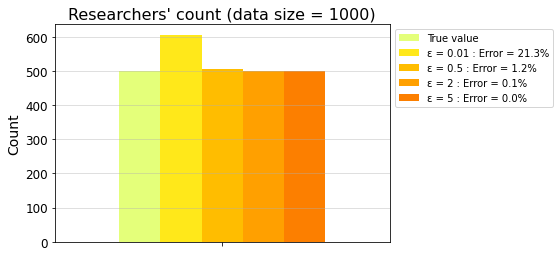

In [69]:
epsilons = [0.01, 0.5, 2, 5]
errors = []

dp_results = {}
dp_results["true_count"] = [true_count]

# evaluating on different values of epsilon
for epsilon in epsilons:
    private_count = laplace_mechanism(true_count, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_count]
    errors.append(percentage_error(true_count, private_count))

# visualise data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

### 3.3. Sum of researchers' salary <a id="cell33"></a>

##### True sum

In [51]:
true_sum_salary = sum(data['salary'])
print(f"True sum of the researchers' salary: {true_sum_salary}")

True sum of the researchers' salary: 3565679.3292220496


#### Settings the bounds 

Clamping bounds for min and max BERD contributions by a firm 
The data is clamped to be within min and max bounds in order to limit
the influence any one firm has on the query. If these bounds are too 
tight, the release may be biased, because values outside these bounds
are replaced with the nearest bound. On the other hand, if these bounds 
are too wide, the respective release will have greater variance.

##### Distribution of researchers' salary

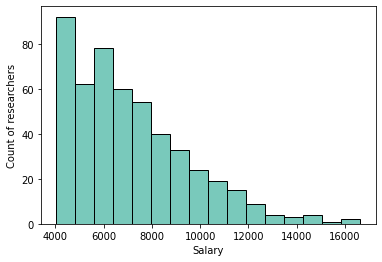

In [70]:
sns.histplot(data['salary'], color=colors[0])
plt.xlabel('Salary')
plt.ylabel('Count of researchers');

##### True bounded sum

In [72]:
# setting the clamping bounds 
lower_bound = 6000
upper_bound = 9000

# applying clamping 
# - values less than `lower_bound` will be clipped to `lower_bound` 
# - values greater than `upper_bound` will be clipped to `upper_bound` 
data['bounded_salary'] = data['salary'].clip(lower=lower_bound, upper=upper_bound)

# computing sum on the bounded values
true_bounded_sum_salary = sum(data['bounded_salary'])

print(f"True bounded sum of the researchers' salary: {true_bounded_sum_salary}")

True bounded sum of the researchers' salary: 4500000.0


##### Private sum

In [54]:
# sensivity of the sum query in this case is the upper_bound
# reason: maximum the sum query's output will change on adding/removing a row is the `upper_bound`
sensitivity = upper_bound 
epsilon = 0.1

# applying laplacian mechanism
private_sum_salary = laplace_mechanism(true_bounded_sum_salary, sensitivity, epsilon)

print(f"Private sum of the researchers's salary: {private_sum_salary} with error: {percentage_error(true_sum_salary, private_sum_salary)}%")

Private sum of the researchers's salary: 4511820.411026288 with error: 26.53%


#### 3.3.1. Impact of epsilon <a id="cell331"></a>

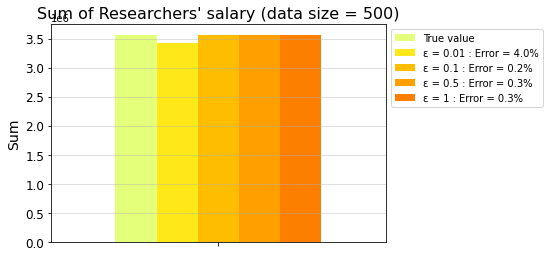

In [55]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_sum_salary = laplace_mechanism(true_sum_salary, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_sum_salary]
    errors.append(percentage_error(true_sum_salary, private_sum_salary))

# visualise data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

#### 3.3.2. Impact of clamping bounds <a id="cell332"></a>

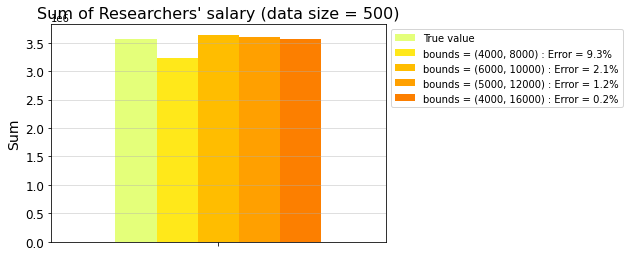

In [56]:
epsilons = 0.1
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]


bounds = [(4000, 8000), (6000, 10000), (5000, 12000), (4000, 16000)]

# evaluating on different values of clamping bounds
for l, u in bounds:
    # setting sensitivity of the sum query as the `upper_bound`
    sensitivity = u
    
    # applying clamping 
    data['bounded_salary'] = data['salary'].clip(lower=l, upper=u)

    # sum of the bounded salaries
    true_bounded_sum_salary = sum(data['bounded_salary'])
    
    # applying laplace mechanism
    private_sum_salary = laplace_mechanism(true_bounded_sum_salary, sensitivity, epsilon)
    
    dp_results[f"bounds_{str(l)}_{str(u)}"] = [private_sum_salary]
    errors.append(percentage_error(true_sum_salary, private_sum_salary))

# visualise data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'bounds', bounds, errors, ylabel, title, labels, (6, 4))

### 3.4. Mean of researchers' salary (with post-processing) <a id="cell34"></a>

##### True mean

In [57]:
true_mean_salary = true_sum_salary/true_count
print(f"True mean of the researchers's salary: {true_mean_salary}")

True mean of the researchers's salary: 7131.358658444099


##### Private mean

In [58]:
private_mean_salary = private_sum_salary/private_count
print(f"Private mean of the researchers's salary: {private_mean_salary} with error: {percentage_error(true_mean_salary, private_mean_salary)}%")

Private mean of the researchers's salary: 7142.139094408527 with error: 0.15%


## Parallel composition 

Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one k chunk - so even if there are  chunks in total (and therefore k runs of the mechanism), the mechanism runs exactly once on the data of each individual.

### 3.5. Count of researchers by sector (with parallel composition) <a id="cell35"></a>

We will assume that each researcher belongs to only one sector. 

Note: If a reseacher belongs to more than one sector than sensivity of the query will increase. Moreover, we need to apply bounds on the maximum sectors a researcher can belong to prevent scaling of the noise. 

##### **True** count of the researchers by sector

In [59]:
true_counts_by_sector = data['sector'].value_counts().to_frame()
true_counts_by_sector

,sector
Healthcare,139
Agricultural,128
Aerospace,123
Engineering,110


##### **Private** count of the researchers by sector

This analysis has a total privacy loss of the set epsilon value (in this case 1), even though we release many results

In [60]:
# sensitivity of the query is 1 
sensitivity = 1 
# setting the epsilon 
epsilon = 1

# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
# adding noise
private_count_by_sector = data['sector'].value_counts().apply(add_laplace_noise)

private_count_by_sector.to_frame()

,sector
Healthcare,138.847226
Agricultural,128.461195
Aerospace,123.162125
Engineering,109.856542


#### Impact of epsilon on the query's output 

In [61]:
true_counts_by_sector_dict = dict(true_counts_by_sector['sector'])

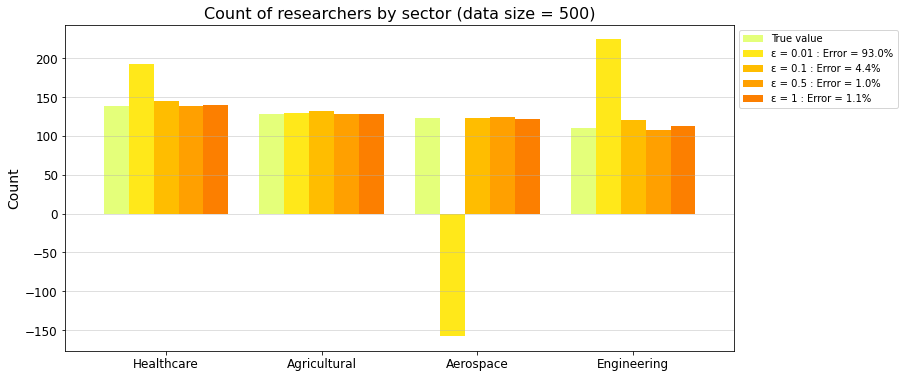

In [62]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}

true_counts_by_sector = true_counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_counts_by_sector = [laplace_mechanism(true_count, sensitivity, epsilon) for true_count in true_counts_by_sector]
    
    dp_results[f"epsilon_{epsilon}"] = private_counts_by_sector
    error = sum([percentage_error(tc, pc) for  tc, pc in zip(true_counts_by_sector, private_counts_by_sector)])/num_sectors
    errors.append(error)

# visualise data 
labels = true_counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"

visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (12, 6))

### 3.6. Count of researchers by sector and academic degree (with parallel composition) <a id="cell36"></a>

##### **True** count of the researchers by sector and academic degree

In [63]:
pd.crosstab(data['sector'], data['degree'])

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,27,24,15,28,29
Agricultural,29,29,15,33,22
Engineering,20,20,18,30,22
Healthcare,31,26,24,31,27


##### **Private** count of the researchers by sector and academic degree

In [64]:
sensitivity = 1 
epsilon = 0.5

true_count_by_degree_and_sector = pd.crosstab(data['sector'], data['degree'])

# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
true_count_by_degree_and_sector.applymap(add_laplace_noise)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,24.540831,23.720775,13.589367,22.553431,28.913828
Agricultural,27.938312,29.611940,12.797780,27.674208,18.039344
Engineering,17.726772,20.618764,17.800811,29.626962,24.580451
Healthcare,31.169256,25.375905,26.101779,31.798654,22.481993


### 4. Impact of Dataset Size <a id="cell4"></a>

In [73]:
# reading the csv file 
data_10000 = pd.read_csv("data/simulated_data_10000.csv")

data_size = len(data_10000)

print(f"Number of rows in the dataset {data_size}")
data_10000.head(5)

Number of rows in the dataset 10000


,NRIC,researcher_name,sector,salary,degree
0,F1152084W,Maggie Sanchez,Healthcare,4859.404308,Bachelors
1,G9330770O,Phyllis Cantrell,Healthcare,9039.374679,PhD
2,T3788352J,Clinton Asmus,Agricultural,9693.006032,Post-grad
3,S1809620E,Linda Dedeke,Healthcare,14900.529351,Bachelors
4,G8105426O,Mary Ruud,Agricultural,11984.982917,PhD


{'true_sum': [3565679.3292220496], 'dataset_size_200': [1469524.3823139425], 'dataset_size_500': [3597891.4802020798], 'dataset_size_1000': [7142104.915300089], 'dataset_size_10000': [71557382.3308202]}


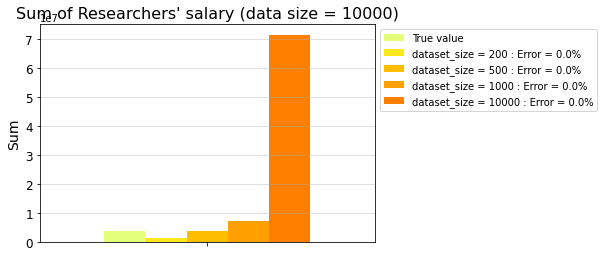

In [80]:
dataset_sizes = [200, 500, 1000, 10000]
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]

for dataset_size in dataset_sizes:
    
    true_sum = sum(data_10000["salary"][:dataset_size])
    
    # applying laplace mechanism
    private_sum_salary = laplace_mechanism(true_sum, sensitivity, epsilon)
    
    dp_results[f"dataset_size_{dataset_size}"] = [private_sum_salary]
    errors.append(percentage_error(true_sum, private_sum_salary))

print(dp_results)
# visualise data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'dataset_size', dataset_sizes, errors, ylabel, title, labels, (6, 4))